In [1]:
from sklearn.cross_decomposition import PLSRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import cross_val_predict
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# LOAD DATASET

data = pd.read_csv('D:/data/train/salt_content_ham2.csv', index_col=0)
data.head()

,band1,band2,band3,band4,band5,band6,band7,band8,band9,band10,...,band196,band197,band198,band199,band200,band201,band202,band203,band204,Salt
0,0.284257,0.249366,0.224309,0.204326,0.189497,0.178146,0.168257,0.161248,0.156066,0.152212,...,0.447807,0.454861,0.462858,0.463716,0.476962,0.481532,0.486014,0.495068,0.488017,0.638805
1,0.270824,0.235305,0.205166,0.185430,0.169601,0.156309,0.146676,0.139072,0.132898,0.128366,...,0.431991,0.439993,0.440340,0.452060,0.456321,0.473419,0.481597,0.490299,0.474413,0.767233
2,0.278932,0.237543,0.210911,0.187438,0.170400,0.157867,0.146440,0.138468,0.132184,0.127973,...,0.414244,0.414589,0.423431,0.434509,0.439365,0.456173,0.462708,0.472729,0.478105,0.650742
3,0.349498,0.300779,0.267037,0.240654,0.222573,0.209150,0.197557,0.189338,0.183519,0.180260,...,0.521007,0.530230,0.529855,0.541250,0.558598,0.562306,0.582928,0.578221,0.579865,0.579592
4,0.268250,0.229010,0.201534,0.179562,0.162913,0.151118,0.141468,0.133970,0.128221,0.125406,...,0.413080,0.420535,0.429221,0.439037,0.443499,0.458375,0.464223,0.473092,0.461016,0.557653


In [3]:
# ORGANIZE DATA

Y = data['Salt']
X = data.values[:,:-1]

In [8]:
# METHODS

# Multiplicative scatter corection
def msc(input_data, reference=None):
    ''' Perform Multiplicative scatter correction'''

    # Baseline correction
    for i in range(input_data.shape[0]):
        input_data[i,:] -= input_data[i,:].mean()

    # Get the reference spectrum. If not given, estimate from the mean    
    if reference is None:    
        # Calculate mean
        matm = np.mean(input_data, axis=0)
    else:
        matm = reference

    # Define a new data matrix and populate it with the corrected data    
    output_data = np.zeros_like(input_data)
    for i in range(input_data.shape[0]):
        # Run regression
        fit = np.polyfit(matm, input_data[i,:], 1, full=True)
        # Apply correction
        output_data[i,:] = (input_data[i,:] - fit[0][1]) / fit[0][0] 

    return (output_data, matm)

# Standard normal Variate
def snv(input_data):
  
    # Define a new array and populate it with the corrected data  
    output_data = np.zeros_like(input_data)
    for i in range(input_data.shape[0]):

        # Apply correction
        output_data[i,:] = (input_data[i,:] - np.mean(input_data[i,:])) / np.std(input_data[i,:])

    return output_data

def pls_variable_selection(X, y, max_comp):
    
    # Define MSE array to be populated
    mse = np.zeros((max_comp,X.shape[1]))

    # Loop over the number of PLS components
    for i in range(max_comp):
        
        # Regression with specified number of components, using full spectrum
        pls1 = PLSRegression(n_components=i+1)
        pls1.fit(X, y)
        
        # Indices of sort spectra according to ascending absolute value of PLS coefficients
        sorted_ind = np.argsort(np.abs(pls1.coef_[:,0]))

        # Sort spectra accordingly 
        Xc = X[:,sorted_ind]

        # Discard one wavelength at a time of the sorted spectra,
        # regress, and calculate the MSE cross-validation
        for j in range(Xc.shape[1]-(i+1)):

            pls2 = PLSRegression(n_components=i+1)
            pls2.fit(Xc[:, j:], y)
            
            y_cv = cross_val_predict(pls2, Xc[:, j:], y, cv=5)

            mse[i,j] = mean_squared_error(y, y_cv)
    
        comp = 100*(i+1)/(max_comp)
        stdout.write("\r%d%% completed" % comp)
        stdout.flush()
    stdout.write("\n")

    # # Calculate and print the position of minimum in MSE
    mseminx,mseminy = np.where(mse==np.min(mse[np.nonzero(mse)]))

    print("Optimised number of PLS components: ", mseminx[0]+1)
    print("Wavelengths to be discarded ",mseminy[0])
    print('Optimised MSEP ', mse[mseminx,mseminy][0])
    stdout.write("\n")
    # plt.imshow(mse, interpolation=None)
    # plt.show()


    # Calculate PLS with optimal components and export values
    pls = PLSRegression(n_components=mseminx[0]+1)
    print("PLS: ", str(pls))
    pls.fit(X, y)
        
    sorted_ind = np.argsort(np.abs(pls.coef_[:,0]))

    Xc = X[:,sorted_ind]

    return(Xc[:,mseminy[0]:],mseminx[0]+1,mseminy[0], sorted_ind)

def simple_pls_cv(X, y, n_comp):

    # Run PLS with suggested number of components
    pls = PLSRegression(n_components=n_comp)
    pls.fit(X, y)
    y_c = pls.predict(X)
    
    import pickle
    # Save to file in the current working directory
    pkl_filename = "pickle_pls_model.pkl"
    with open(pkl_filename, 'wb') as file:
        pickle.dump(pls, file)
    print("Done file")
    params = pls.get_params()
    print(params)
    # Cross-validation
    y_cv = cross_val_predict(pls, X, y, cv=10)    

    # Calculate scores for calibration and cross-validation
    score_c = r2_score(y, y_c)
    score_cv = r2_score(y, y_cv)

    # Calculate mean square error for calibration and cross validation
    mse_c = mean_squared_error(y, y_c)
    mse_cv = mean_squared_error(y, y_cv)

    print('R2 calib: %5.3f'  % score_c)
    print('R2 CV: %5.3f'  % score_cv)
    print('MSE calib: %5.3f' % mse_c)
    print('MSE CV: %5.3f' % mse_cv)

    # Plot regression 

    z = np.polyfit(y, y_cv, 1)
    with plt.style.context(('ggplot')):
        fig, ax = plt.subplots(figsize=(9, 5))
        ax.scatter(y_cv, y, c='red', edgecolors='k')
        ax.plot(z[1]+z[0]*y, y, c='blue', linewidth=1)
        ax.plot(y, y, color='green', linewidth=1)
        plt.title('$R^{2}$ (CV): '+str(score_cv))
        plt.xlabel('Predicted $^{\circ}$Salt')
        plt.ylabel('Measured $^{\circ}$Salt')
        
        plt.show()

100% completed
Optimised number of PLS components:  10
Wavelengths to be discarded  168
Optimised MSEP  2.0517541334165346

PLS:  PLSRegression(n_components=10)
Done sorting file
Done file
{'copy': True, 'max_iter': 500, 'n_components': 10, 'scale': True, 'tol': 1e-06}
R2 calib: 0.924
R2 CV: 0.885
MSE calib: 1.126
MSE CV: 1.709


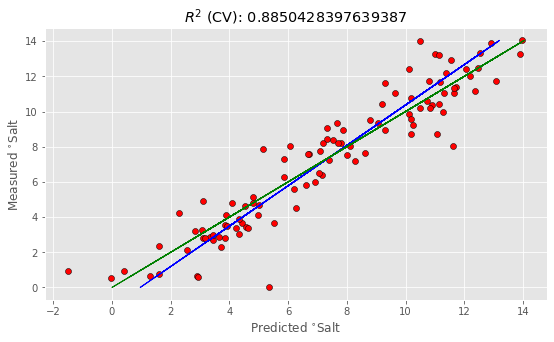

In [13]:
# APPLICATION

Xmsc = msc(X)[0] # Take the first element of the output tuple
Xsnv = snv(Xmsc)

from scipy.signal import savgol_filter
X1snv = savgol_filter(Xsnv, 9, polyorder = 2, deriv=1)

# Variable Selection
from sys import stdout
opt_Xc, ncomp, wav, sorted_ind = pls_variable_selection(X1snv, Y, 15)

import pickle
# Save to file in the current working directory
pkl_filename = "pickle_var_select.pkl"
with open(pkl_filename, 'wb') as file:
    pickle.dump([sorted_ind, wav], file)
print("Done sorting file")

simple_pls_cv(opt_Xc, Y, ncomp)

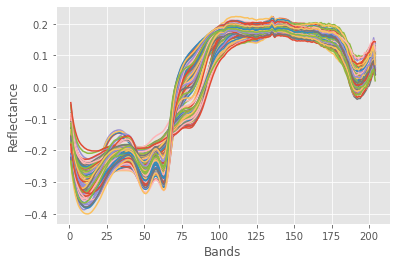

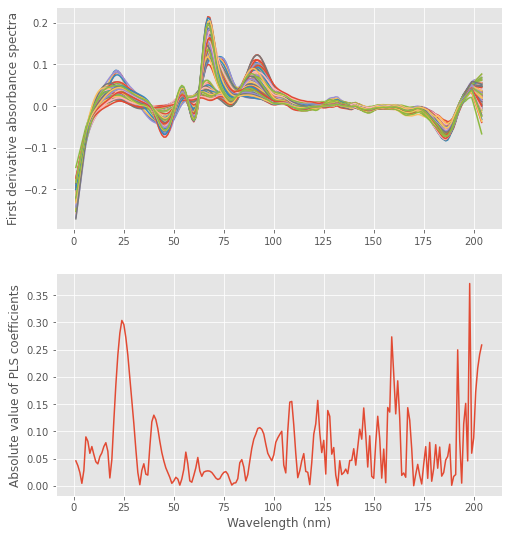

In [6]:
# OTHER PLOTS
wl = np.arange(1,205,1)
# Define the PLS regression object
pls = PLSRegression(n_components=8)
# Fit data
pls.fit(X1snv, Y)

with plt.style.context(('ggplot')):
    plt.plot(wl, X.T)
    plt.xlabel('Bands')
    plt.ylabel('Reflectance')
plt.show()

plt.figure(figsize=(8,9))
with plt.style.context(('ggplot')):
    ax1 = plt.subplot(211)
    plt.plot(wl, X1snv.T)
    plt.ylabel('First derivative absorbance spectra')
    
    ax2 = plt.subplot(212, sharex=ax1)
    plt.plot(wl, np.abs(pls.coef_[:,0]))
    plt.xlabel('Wavelength (nm)')
    plt.ylabel('Absolute value of PLS coefficients')

    plt.show()

In [7]:
#######################################################################################################################

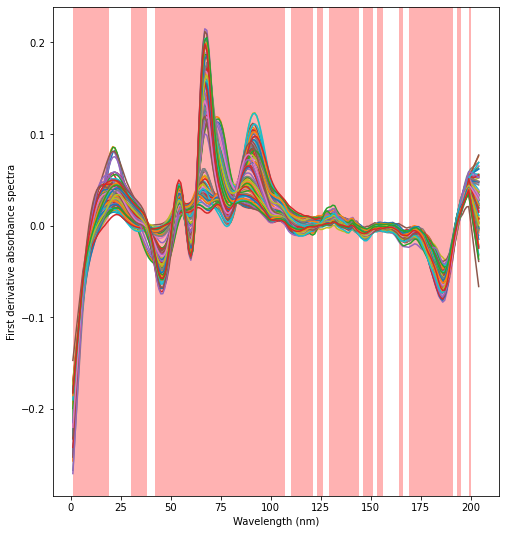

In [8]:
# Show discarded bands

sorted_ind = np.argsort(np.abs(pls.coef_[:,0]))

# Sort spectra according to ascending absolute value of PLS coefficients
Xc = X1snv[:,sorted_ind]

# Get a boolean array according to the indices that are being discarded
ix = np.in1d(wl.ravel(), wl[sorted_ind][:wav])

import matplotlib.collections as collections

# Plot spectra with superimpose selected bands
fig, ax = plt.subplots(figsize=(8,9))
with plt.style.context(('ggplot')):
    ax.plot(wl, X1snv.T)
    plt.ylabel('First derivative absorbance spectra')
    plt.xlabel('Wavelength (nm)')

collection = collections.BrokenBarHCollection.span_where(
    wl, ymin=-1, ymax=1, where=ix == True, facecolor='red', alpha=0.3)
ax.add_collection(collection)

plt.show()